In [228]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import warnings
from tqdm import tqdm
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
from scipy import sparse
from sklearn.model_selection import StratifiedKFold
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import xgboost as xgb
import seaborn as sns

In [229]:
train=pd.read_csv('/root/kesai/train_set.csv',na_values=[-1, "unknown"])
test =pd.read_csv('/root/kesai/test_set.csv',na_values=[-1, "unknown"])
data= pd.concat([train,test])

In [230]:
data.head()

,ID,age,balance,campaign,contact,day,default,duration,education,housing,job,loan,marital,month,pdays,poutcome,previous,y
0,1,43,291.0,2,NaN,9,no,150,tertiary,yes,management,no,married,may,NaN,NaN,0,0.0
1,2,42,5076.0,1,cellular,7,no,99,primary,yes,technician,no,divorced,apr,251.0,other,2,0.0
2,3,47,104.0,2,cellular,14,no,77,secondary,yes,admin.,yes,married,jul,NaN,NaN,0,0.0
3,4,28,-994.0,2,cellular,18,no,174,secondary,yes,management,yes,single,jul,NaN,NaN,0,0.0
4,5,42,2974.0,5,NaN,21,no,187,secondary,yes,technician,no,divorced,may,NaN,NaN,0,0.0


In [231]:
len_train = len(train)
cols_train = len(train.columns)
len_test = len(test)
cols_test = len(test.columns)
print(f"train_len:{len_train} cols_train:{cols_train} test_len:{len_test} cols_test:{cols_test}")

train_len:25317 cols_train:18 test_len:10852 cols_test:17


In [232]:
train.columns

Index(['ID', 'age', 'job', 'marital', 'education', 'default', 'balance',
       'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign',
       'pdays', 'previous', 'poutcome', 'y'],
      dtype='object')

In [233]:
col = train.columns
bincol = ["default", "housing", "loan"]
catcol = ["marital", "education", "contact", "poutcome", "job"]
othercol = ['age',
 'balance',
 'day',
 'month',
 'duration',
 'campaign',
 'pdays',
 'previous']
def rename_col(st):
    if st in bincol:
        return st+"_bin"
    elif st in catcol:
        return st + "_cat"
    else:
        return st
train.columns = train.columns.map(lambda x:rename_col(x))
test.columns = test.columns.map(lambda x:rename_col(x))
bincol = list(map(lambda x: x+"_bin", bincol))
catcol = list(map(lambda x: x+"_cat", catcol))

In [234]:
train.columns

Index(['ID', 'age', 'job_cat', 'marital_cat', 'education_cat', 'default_bin',
       'balance', 'housing_bin', 'loan_bin', 'contact_cat', 'day', 'month',
       'duration', 'campaign', 'pdays', 'previous', 'poutcome_cat', 'y'],
      dtype='object')

In [235]:
train.isnull().any()[train.isnull().any()]

job_cat          True
education_cat    True
balance          True
contact_cat      True
pdays            True
poutcome_cat     True
dtype: bool

In [236]:
test.isnull().any()[test.isnull().any()]

job_cat          True
education_cat    True
balance          True
contact_cat      True
pdays            True
poutcome_cat     True
dtype: bool

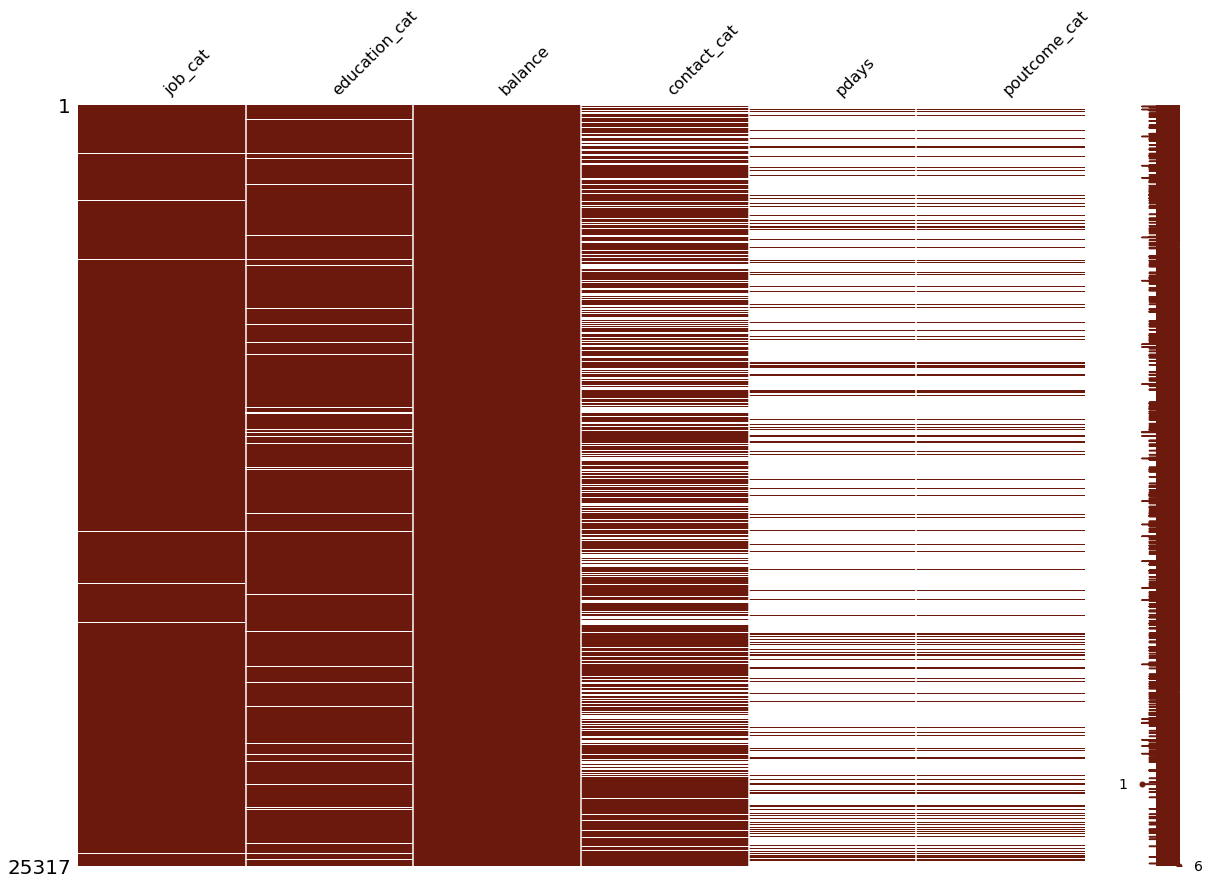

In [237]:
import missingno as msno
col_missing = train.isnull().any()[train.isnull().any()].index
msno.matrix(df=train[col_missing], figsize=(20, 14), color=(0.42, 0.1, 0.05),)

In [238]:
train[col_missing].apply(lambda c:len(c[c.isnull()])).sort_values()

balance             25
job_cat            163
education_cat     1065
contact_cat       7281
pdays            20674
poutcome_cat     20677
dtype: int64

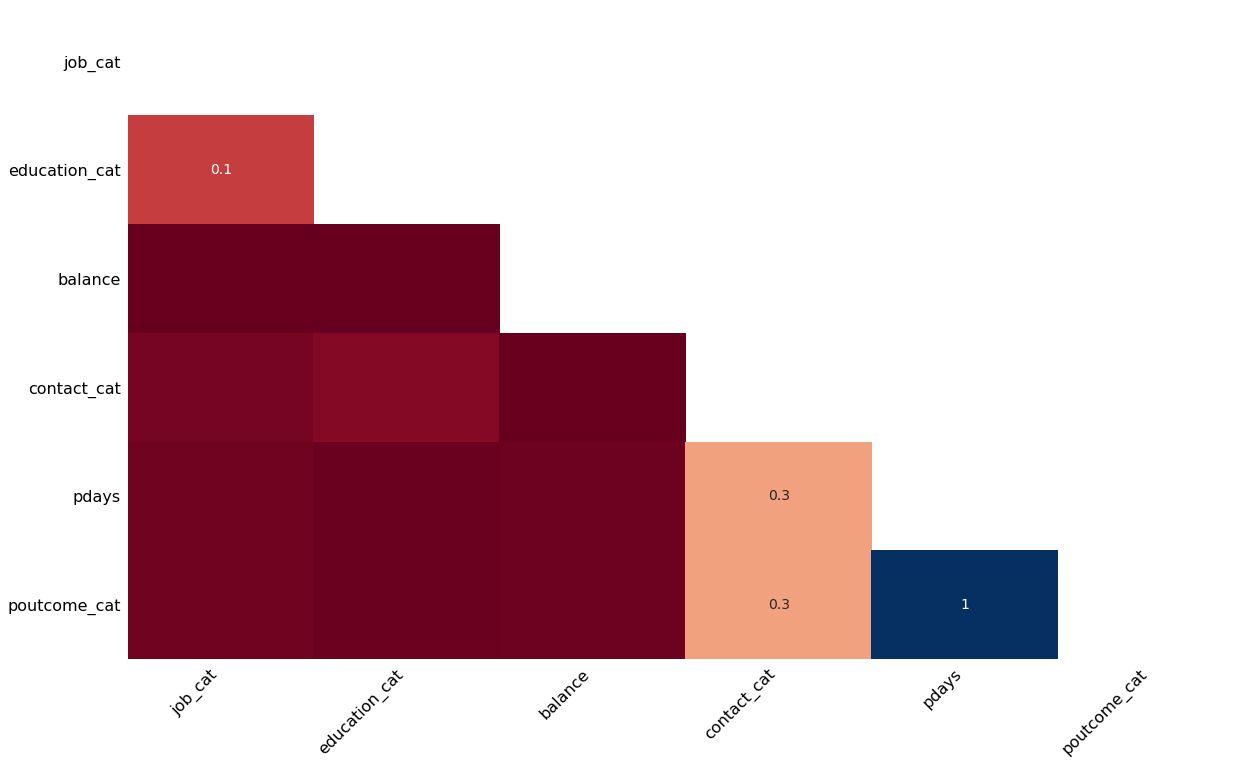

In [239]:
msno.heatmap(df=train[col_missing])

In [240]:
test[col_missing].apply(lambda c:len(c[c.isnull()])).sort_values()

balance            18
job_cat            60
education_cat     448
contact_cat      3112
pdays            8875
poutcome_cat     8877
dtype: int64

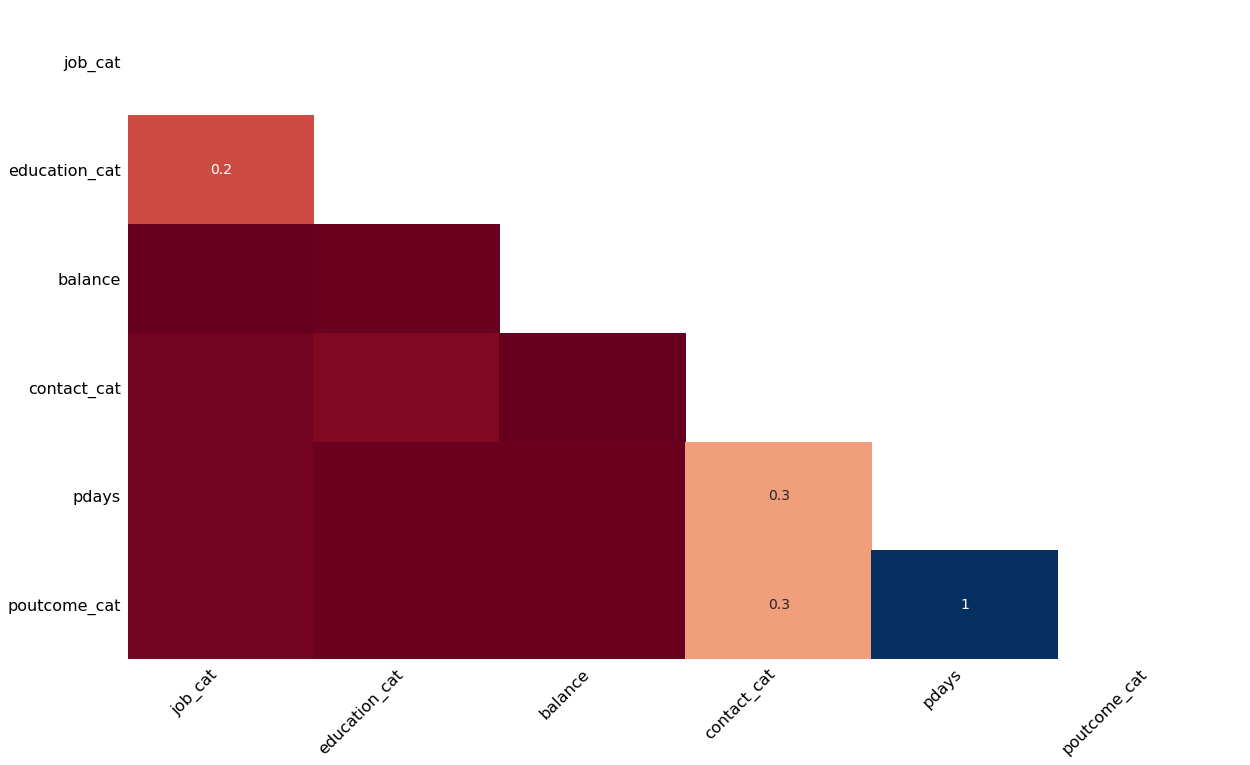

In [241]:
msno.heatmap(df=test[col_missing])

In [242]:
target = train['y']
target.value_counts()

0    22356
1     2961
Name: y, dtype: int64

In [243]:
print(bincol, othercol)

['default_bin', 'housing_bin', 'loan_bin'] ['age', 'balance', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous']


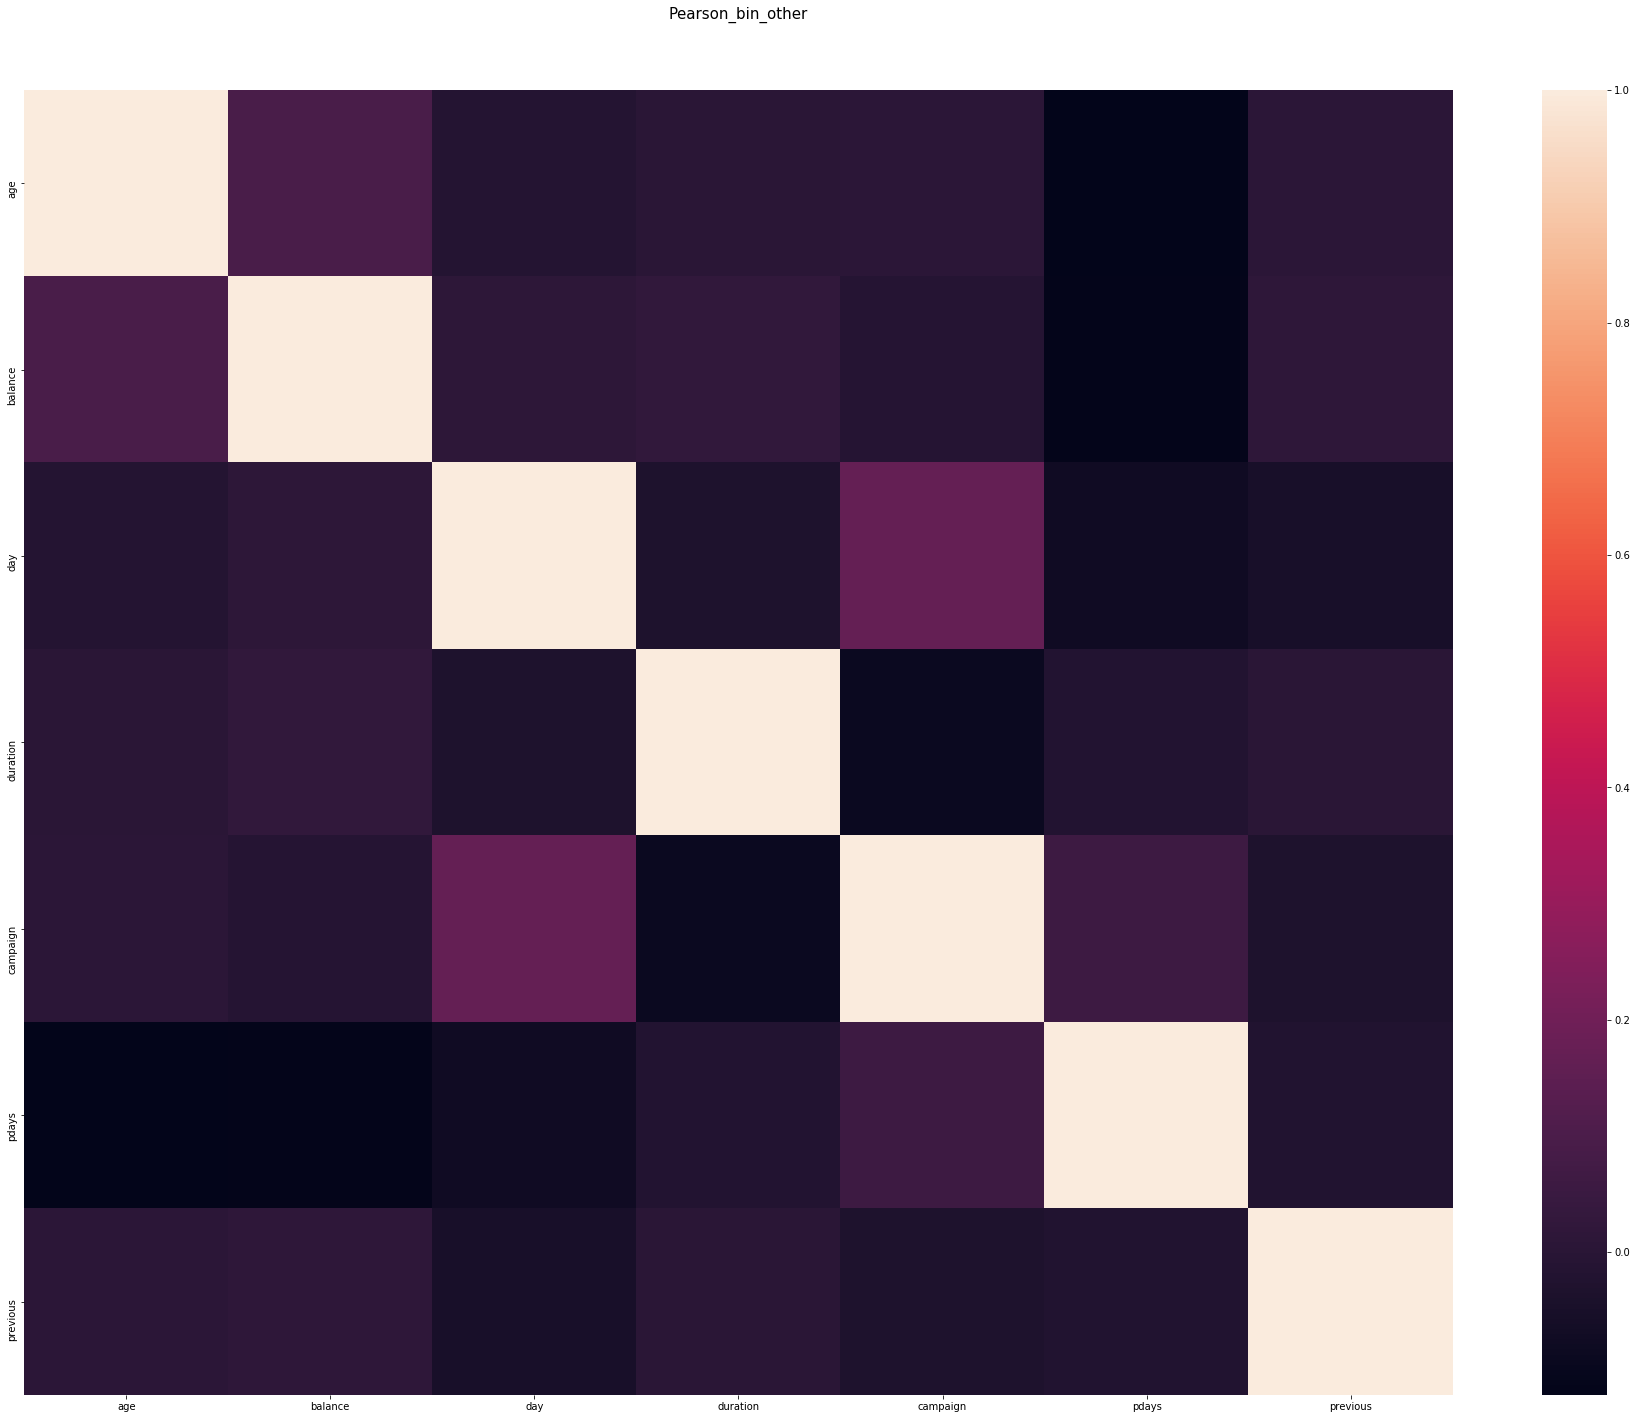

In [244]:
colormap = plt.cm.magma
plt.figure(figsize=(32,24))
plt.title(u'Pearson_bin_other', y=1.05, size=15)
sns.heatmap(train[bincol+othercol].corr())

In [245]:
len_train = len(train)
len_test = len(test)
##bin：
#层叠条形图：
import plotly.plotly as py
import plotly.graph_objs as go
from plotly import tools
tools.set_credentials_file(username='1246157447', api_key='mCqFT4Mi3p30A2vjeHkV')

##首先，获得bincol下每个col的0、1、缺失的数量
bin_zero_list = []
bin_one_list = []

for i in bincol:
    temp = train[i].value_counts()
    zero = temp[0]
    one = temp[1]
    nan = len_train - zero - one
    bin_zero_list.append(zero)
    bin_one_list.append(one)

trace_1 = go.Bar(
        x = bincol,
        y = bin_zero_list,
        name = 'Zero Counts'
        )

trace_2 = go.Bar(
        x = bincol,
        y = bin_one_list,
        name = 'One Counts'
        )

bin_plot_data = [trace_1,trace_2]
layout = go.Layout(
        barmode = 'stack')

fig = go.Figure(data = bin_plot_data,layout = layout)
py.iplot(fig, filename='stacked-bar')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~1246157447/0 or inside your plot.ly account where it is named 'stacked-bar'


In [246]:
bin_zero_list = []
bin_one_list = []

for i in bincol:
    temp = test[i].value_counts()
    zero = temp[0]
    one = temp[1]
    nan = len_train - zero - one
    bin_zero_list.append(zero)
    bin_one_list.append(one)

trace_1 = go.Bar(
        x = bincol,
        y = bin_zero_list,
        name = 'Zero Counts'
        )

trace_2 = go.Bar(
        x = bincol,
        y = bin_one_list,
        name = 'One Counts'
        )

bin_plot_data = [trace_1,trace_2]
layout = go.Layout(
        barmode = 'stack')

fig = go.Figure(data = bin_plot_data,layout = layout)
py.iplot(fig, filename='stacked-bar')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~1246157447/0 or inside your plot.ly account where it is named 'stacked-bar'


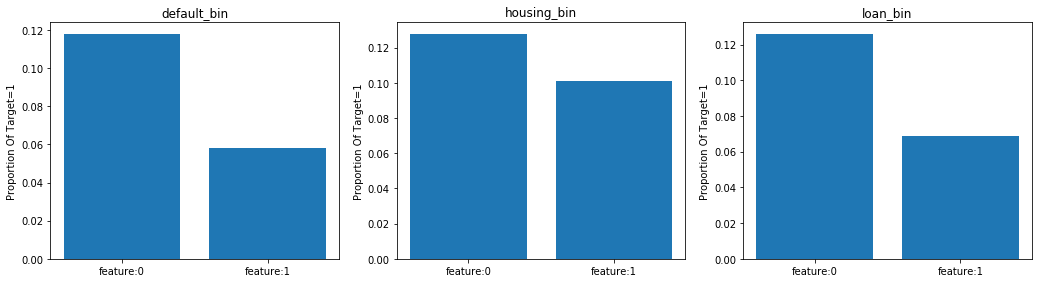

In [247]:
train_1 = train[train.y == 1]
train_0 = train[train.y == 0]
len_train1 = len(train_1)
len_train0 = len(train_0)

k = 0
plt.figure(figsize=(30,20)) 
for x in bincol:
    k = k+1
    temp0 = train_0[x].value_counts()
    bin_zero_t0 = temp0[0]
    bin_one_t0 = temp0[1]
    temp1 = train_1[x].value_counts()
    bin_zero_t1 = temp1[0]
    bin_one_t1 = temp1[1]
    name_0 = 'feature:0'
    name_1 = 'feature:1'
    name = (name_0,name_1)
    #zerolist = (bin_zero_t0/(bin_zero_t0+bin_zero_t1),bin_one_t0/(bin_one_t0+bin_one_t1))
    onelist = (bin_zero_t1/(bin_zero_t0+bin_zero_t1),bin_one_t1/(bin_one_t0+bin_one_t1)) 
    plt.subplot(4,5,k)
    plt.ylabel('Proportion Of Target=1')
    plt.title(x)
    #plt.bar(name,zerolist,color = 'red',width = 0.8,label = 'target:zero')
    plt.bar(name,onelist,width = 0.8,label = 'target:one')

# 多分类特征分析

In [265]:
train_val_eq_1 = train[target == 1]

Index(['job_cat', 'education_cat', 'balance', 'contact_cat', 'pdays',
       'poutcome_cat'],
      dtype='object')


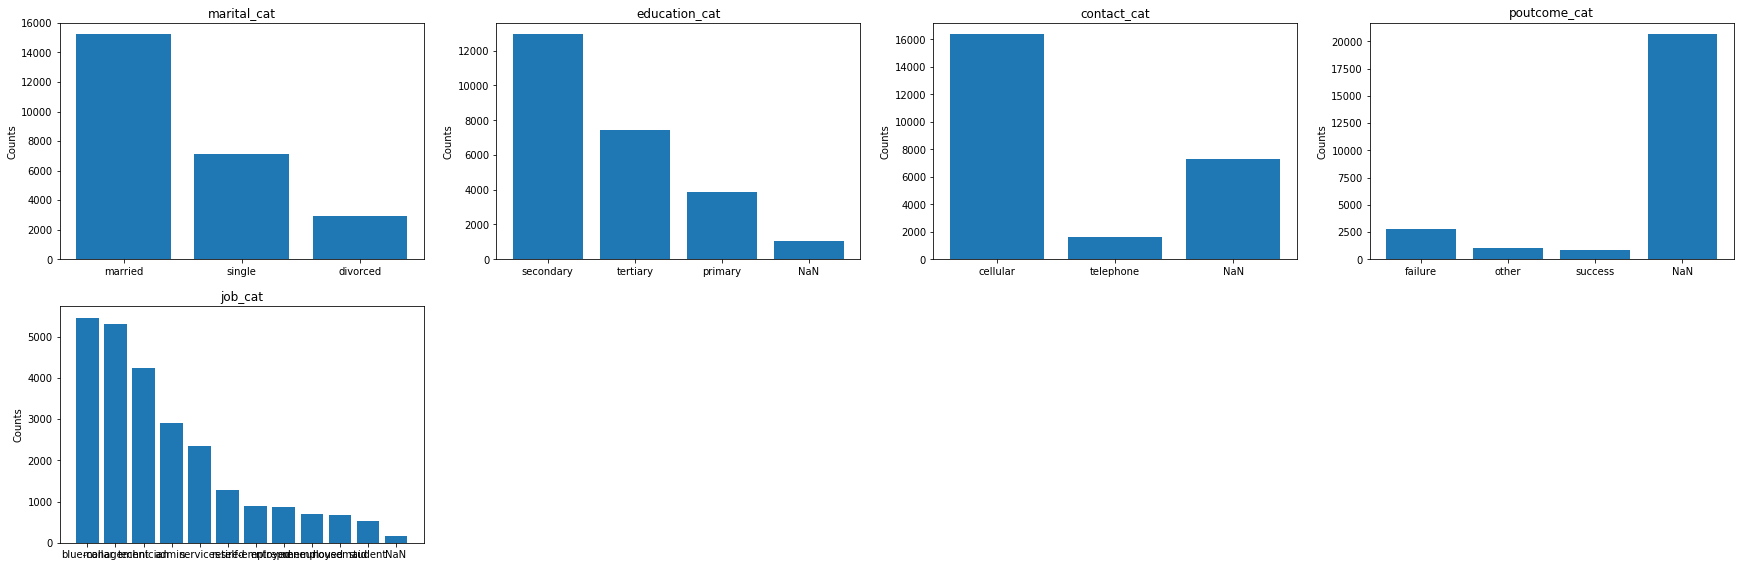

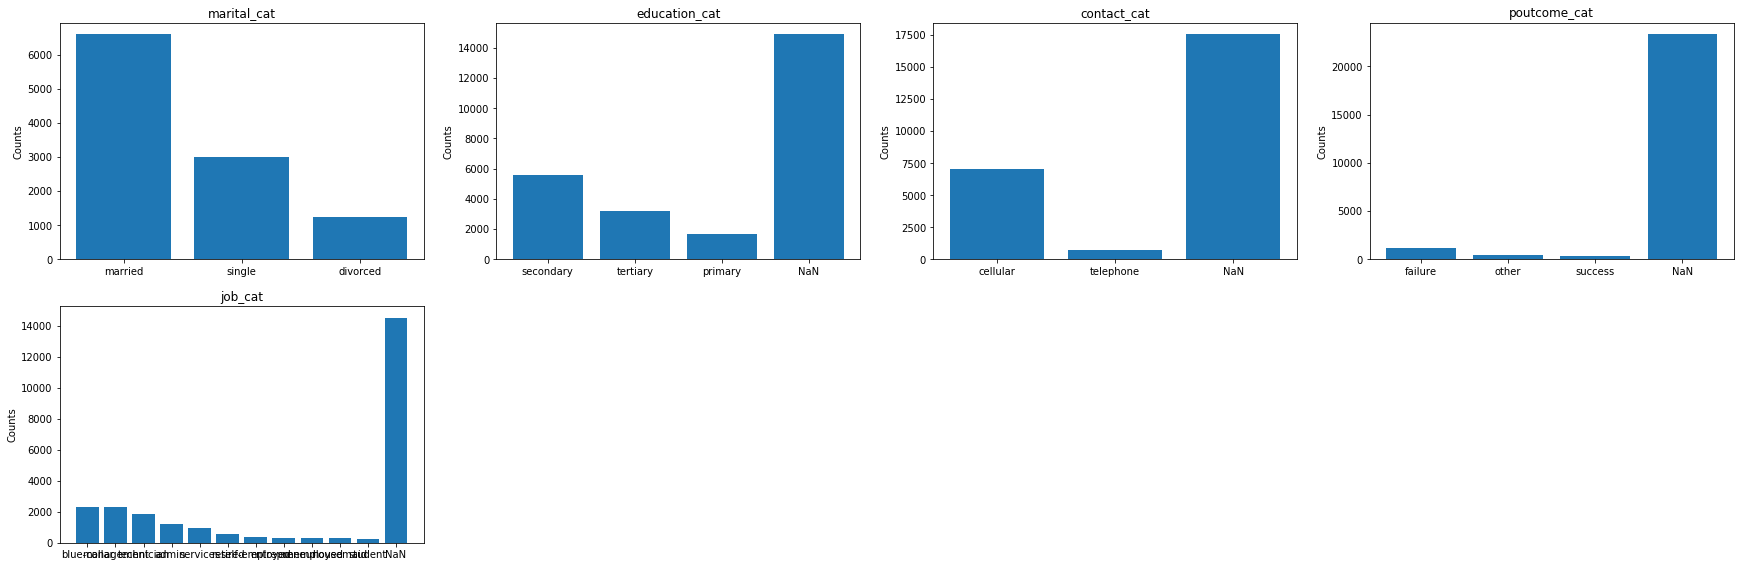

In [249]:
##画每个cat特征的条形分布图：
k = 0
plt.figure(figsize=(30,20)) 
for x in catcol:
    k = k+1
    names = list(train[x].value_counts().index)
    counts = list(train[x].value_counts().values)
    if x in col_missing:
        names.append('NaN')
        counts.append(len_train - sum(counts))
    plt.subplot(4,4,k)
    plt.title(x)
    plt.ylabel('Counts')
    plt.bar(names,counts)
k = 0
plt.figure(figsize=(30,20)) 
for x in catcol:
    k = k+1
    names = list(test[x].value_counts().index)
    counts = list(test[x].value_counts().values)
    if x in col_missing:
        names.append('NaN')
        counts.append(len_train - sum(counts))
    plt.subplot(4,4,k)
    plt.title(x)
    plt.ylabel('Counts')
    plt.bar(names,counts)

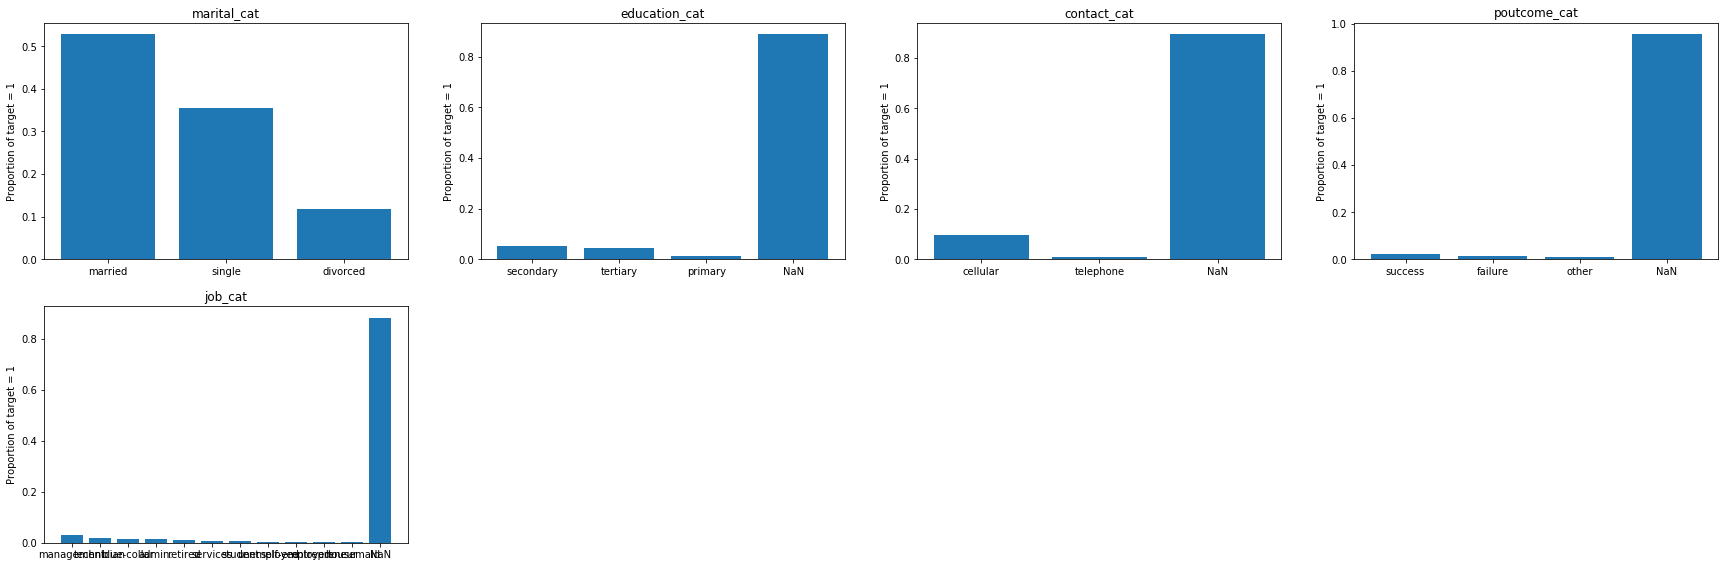

In [266]:
##画每个cat特征的条形分布图：
k = 0
plt.figure(figsize=(30,20)) 
for x in catcol:
    k = k+1
    names = list(train_val_eq_1[x].value_counts().index)
    counts = list(train_val_eq_1[x].value_counts().values)
    if x in col_missing:
        names.append('NaN')
        counts.append(len_train - sum(counts))
    s = sum(counts)
    probs = (np.array(counts)/float(s)).tolist()
    plt.subplot(4,4,k)
    plt.title(x)
    plt.ylabel('Proportion of target = 1')
    plt.bar(names,probs)

# 连续和离散特征分析

In [269]:
for x in othercol:
    v = len(train[x].value_counts())
    print (x+"'s kinds of value:",v)

age's kinds of value: 75
balance's kinds of value: 5735
day's kinds of value: 31
month's kinds of value: 12
duration's kinds of value: 1388
campaign's kinds of value: 43
pdays's kinds of value: 492
previous's kinds of value: 36


In [274]:
conti_other = ['balance','duration','pdays','previous','age']
rankORint_other = [x for x in othercol if x not in conti_other]
print(len(rankORint_other))

3


In [275]:
# k = 0
# plt.figure(figsize=(40,20)) 
# for x in rankORint_other:
#     k = k+1
#     plt.subplot(1,5,k)
#     plt.title(x)
#     plt.ylabel('counts')
#     plt.hist(train[x].dropna())

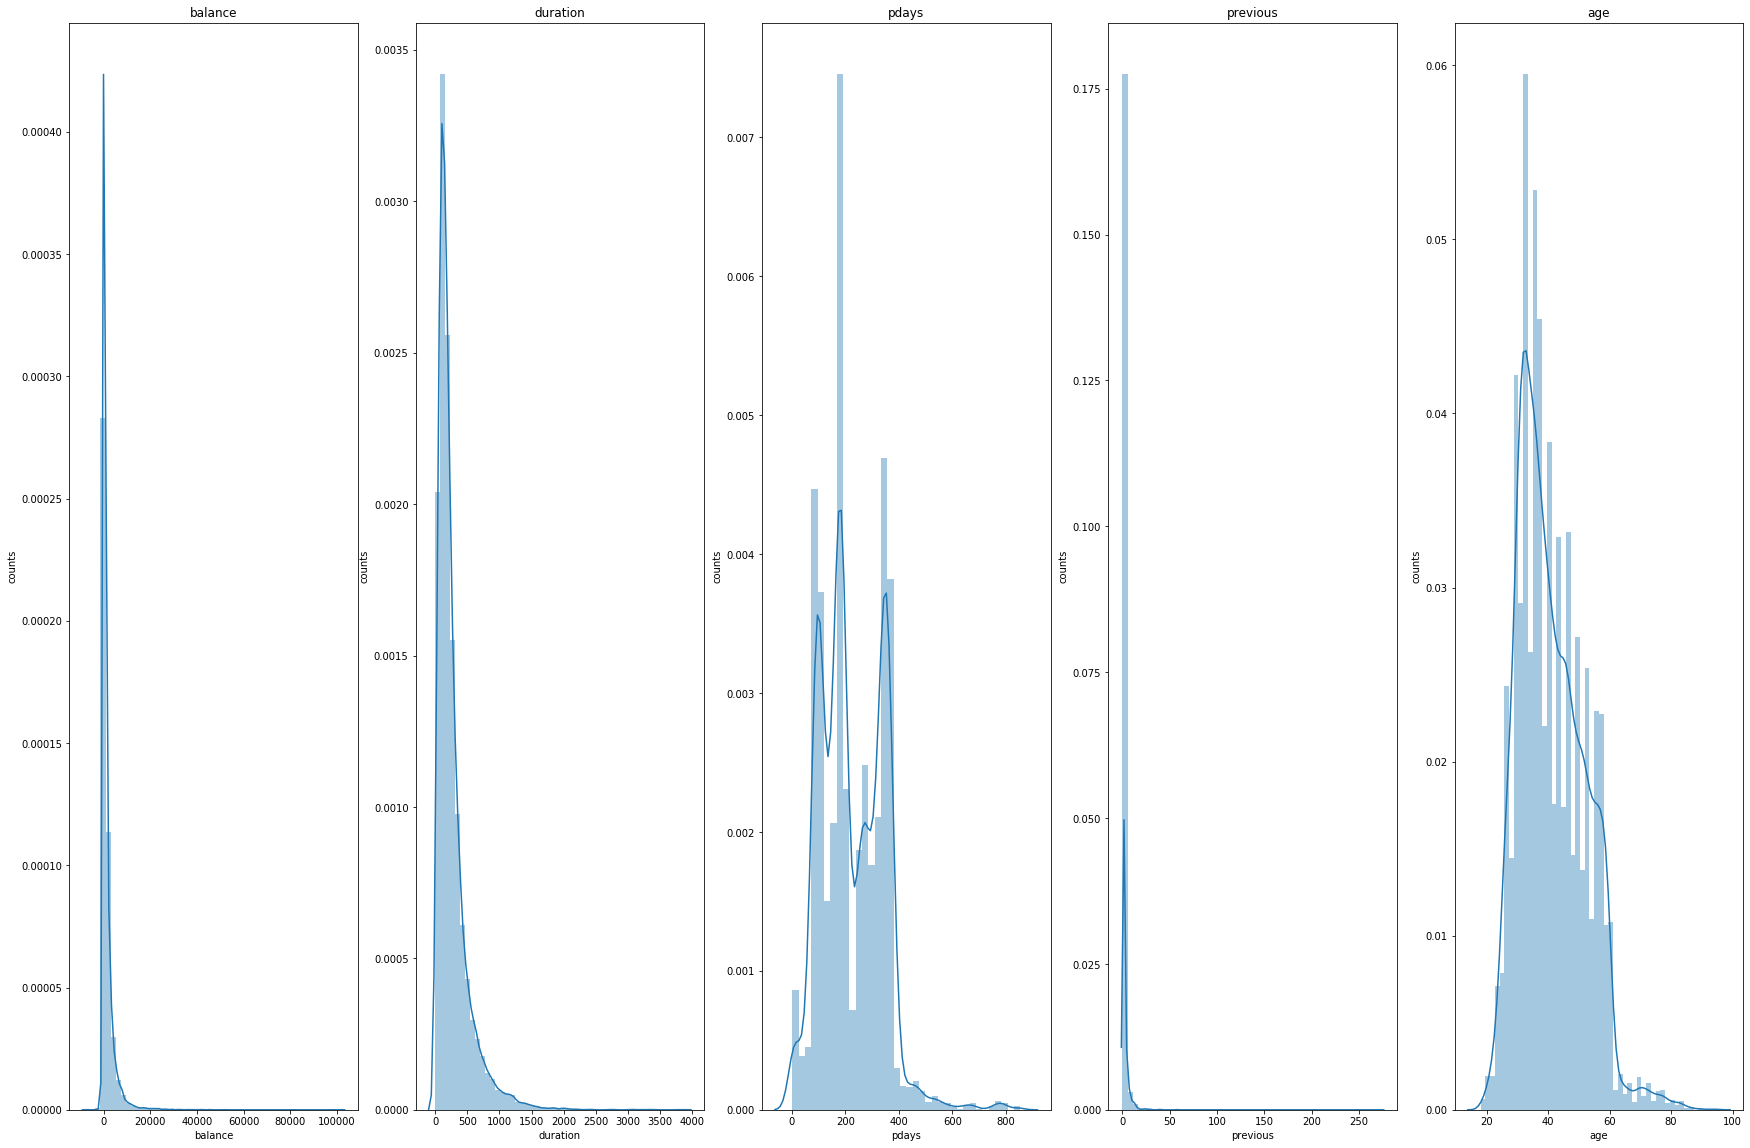

In [277]:
k = 0
plt.figure(figsize=(30,20)) 
for x in conti_other:
    k = k+1
    plt.subplot(1,5,k)
    plt.title(x)
    plt.ylabel('counts')
    sns.distplot(train[x].dropna())

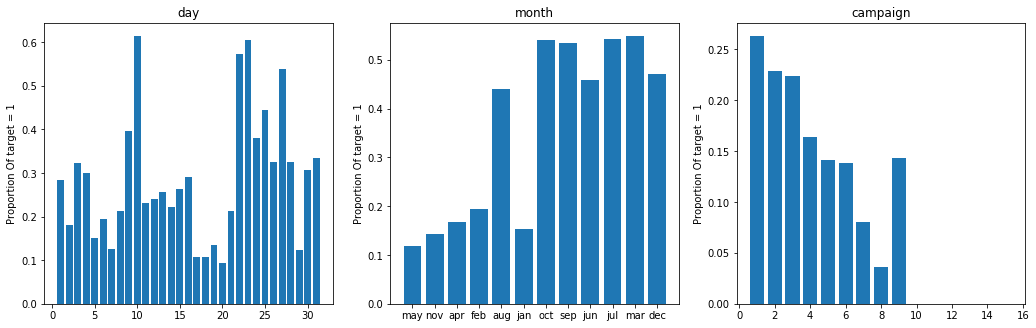

In [278]:
train_rank = train[othercol].copy()
train_rank['y'] = train['y'].copy()
train_rank = train_rank.dropna()
train_rank01 = train_rank[train_rank.y == 1]
train_rank00 = train_rank[train_rank.y == 0]
train_rank_target = train_rank.y
len_train_rank01 = len(train_rank01)
len_train_rank00 = len(train_rank00)

k = 0
plt.figure(figsize=(30,30)) 
for x in rankORint_other:
    k = k+1
    names = list(train_rank[x].value_counts().index)
    counts_0 = train_rank00[x].value_counts()[names]
    counts_1 = train_rank01[x].value_counts()[names]
    counts_0 = counts_0.replace(np.nan,0).values
    counts_1 = counts_1.replace(np.nan,0).values
    prop = counts_1/(counts_1+counts_0)
    prop = list(prop)
    plt.subplot(5,5,k)
    plt.title(x)
    plt.ylabel('Proportion Of target = 1')
    plt.bar(names,prop)

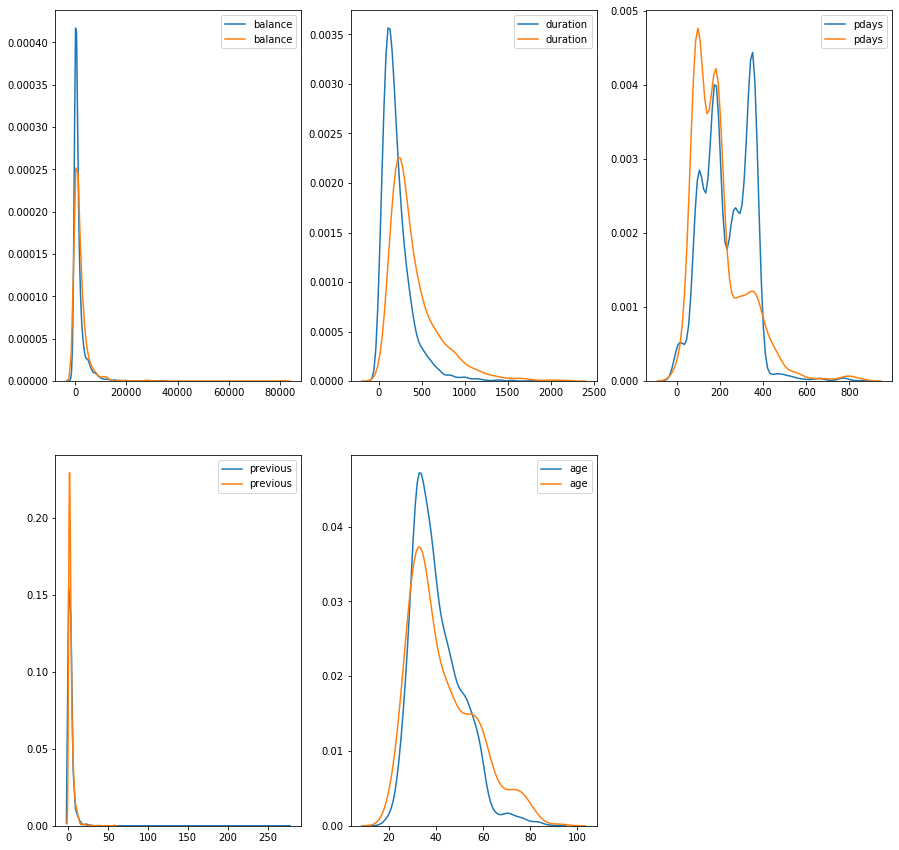

In [280]:
k = 0
plt.figure(figsize=(15,15)) 
for x in conti_other:
    k = k+1
    plt.subplot(2,3,k)
    sns.kdeplot(train_rank00[x])
    sns.kdeplot(train_rank01[x])

[2958, 3]
[1082, 1879]


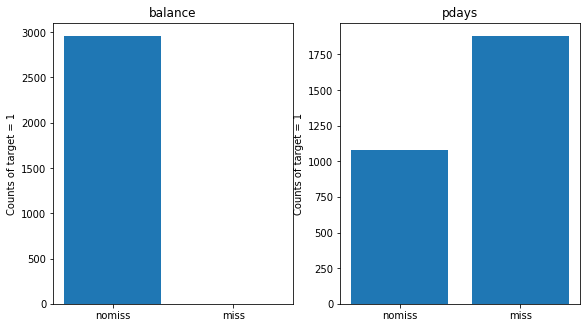

In [319]:
train_rank01 = train[train.y == 1]
plt.figure(figsize=(30,30)) 
k = 0
for x in conti_other:
    if x in col_missing:
        k = k+1
        names = ["nomiss", "miss"]
        counts = list(train_rank01[x].value_counts().values)
        counts = [sum(counts)]
        counts.append(len(train_rank01) - sum(counts))
        print(counts)
        plt.subplot(5,6,k)
        plt.title(x)
        plt.ylabel('Counts of target = 1')
        plt.bar(names,counts)

# 缺失值处理

在前述分析中，我们充分研究了缺失值的存在对于Target变量的影响，获得的信息相当重要：对绝大多数的特征而言，“存在缺失值”这件事情本身就有可能会影响Target变量，因此，简简单单地对其进行插补可能并不可取。

对于多分类变量特征的缺失值，这里选择将缺失值插补为-1，也就是把特征的缺失值视为对应特征的一个全新类别，和其他的所属类别一起参与建模。 
此外，还有2个并非分类变量的特征存在缺失值，其中balance缺失的部分极少，加在一起也只有25个缺失值而已，对这个特征只需要插补，不需要保留缺失信息。而pdays是缺失值数量较高的特征，为了保留缺失信息，建立对应的二分类特征：pdays_miss记录缺失信息，在pdays出现缺失值的时候取1，否则取0。

此外，由于这几个变量的分布都不对称，因此比起均值，插补中位数更有利于维持原始分布，选择插补中位数。

In [320]:
###缺失值处理：

#对于分类特征，把缺失值视为一个新的分类，插补为-1
miss_cat = [x for x in col_missing if x in catcol]
train[miss_cat] = train[miss_cat].replace(np.nan,-1)
#对于连续特征：
miss_nocat = [x for x in col_missing if x not in miss_cat]
train['pdays_miss'] = np.zeros(len_train)
train['pdays_miss'] [train.pdays.isnull()] = 1
test['pdays_miss'] = np.zeros(len_test)
test['pdays_miss'] [test.pdays.isnull()] = 1
train[miss_nocat] = train[miss_nocat].replace(np.nan,train[miss_nocat].median())

In [321]:
train.head()

,ID,age,job_cat,marital_cat,education_cat,default_bin,balance,housing_bin,loan_bin,contact_cat,day,month,duration,campaign,pdays,previous,poutcome_cat,y,pdays_miss
0,1,43,management,married,tertiary,no,291.0,yes,no,-1,9,may,150,2,191.0,0,-1,0,1.0
1,2,42,technician,divorced,primary,no,5076.0,yes,no,cellular,7,apr,99,1,251.0,2,other,0,0.0
2,3,47,admin.,married,secondary,no,104.0,yes,yes,cellular,14,jul,77,2,191.0,0,-1,0,1.0
3,4,28,management,single,secondary,no,-994.0,yes,yes,cellular,18,jul,174,2,191.0,0,-1,0,1.0
4,5,42,technician,divorced,secondary,no,2974.0,yes,no,-1,21,may,187,5,191.0,0,-1,0,1.0


In [324]:
for i in catcol:
    cat_mapping = {label:idx for idx,label in enumerate(set(train[i]))}
    train[i] = train[i].map(cat_mapping)
    test[i] = test[i].map(cat_mapping)
train.head()

,ID,age,job_cat,marital_cat,education_cat,default_bin,balance,housing_bin,loan_bin,contact_cat,day,month,duration,campaign,pdays,previous,poutcome_cat,y,pdays_miss
0,1,43,3,2,1,no,291.0,yes,no,1,9,may,150,2,191.0,0,2,0,1.0
1,2,42,2,1,2,no,5076.0,yes,no,0,7,apr,99,1,251.0,2,1,0,0.0
2,3,47,0,2,0,no,104.0,yes,yes,0,14,jul,77,2,191.0,0,2,0,1.0
3,4,28,3,0,0,no,-994.0,yes,yes,0,18,jul,174,2,191.0,0,2,0,1.0
4,5,42,2,1,0,no,2974.0,yes,no,1,21,may,187,5,191.0,0,2,0,1.0


In [332]:
for i in bincol:
    bin_mapping = {"yes":1, "no":0}
    train[i] = train[i].map(bin_mapping)
    test[i] = test[i].map(bin_mapping)
train.head()

,ID,age,job_cat,marital_cat,education_cat,default_bin,balance,housing_bin,loan_bin,contact_cat,...,pdays,previous,poutcome_cat,y,pdays_miss,marital_cat_rank,education_cat_rank,contact_cat_rank,poutcome_cat_rank,job_cat_rank
0,1,43,0.138973,0.102657,0.150262,0,291.0,1,0,0.039280,...,191.0,0,0.090971,0,1.0,2,1,1,2,3
1,2,42,0.113417,0.119383,0.084200,0,5076.0,1,0,0.148923,...,251.0,2,0.175701,0,0.0,1,2,0,1,2
2,3,47,0.117222,0.102657,0.104885,0,104.0,1,1,0.148923,...,191.0,0,0.090971,0,1.0,2,0,0,2,0
3,4,28,0.138973,0.146430,0.104885,0,-994.0,1,1,0.148923,...,191.0,0,0.090971,0,1.0,0,0,0,2,3
4,5,42,0.113417,0.119383,0.104885,0,2974.0,1,0,0.039280,...,191.0,0,0.090971,0,1.0,1,0,1,2,2


In [336]:
month_mapping = {"jan":1, "feb":2, "mar":3, "apr":4, "may":5, "jun":6, "jul":7, "aug":8, "sep":9, "oct":10, "nov":11, "dec":12}
train["month"] = train["month"].map(month_mapping)
test["month"] = test["month"].map(month_mapping)
train.head()

,ID,age,job_cat,marital_cat,education_cat,default_bin,balance,housing_bin,loan_bin,contact_cat,...,pdays,previous,poutcome_cat,y,pdays_miss,marital_cat_rank,education_cat_rank,contact_cat_rank,poutcome_cat_rank,job_cat_rank
0,1,43,0.138973,0.102657,0.150262,0,291.0,1,0,0.039280,...,191.0,0,0.090971,0,1.0,2,1,1,2,3
1,2,42,0.113417,0.119383,0.084200,0,5076.0,1,0,0.148923,...,251.0,2,0.175701,0,0.0,1,2,0,1,2
2,3,47,0.117222,0.102657,0.104885,0,104.0,1,1,0.148923,...,191.0,0,0.090971,0,1.0,2,0,0,2,0
3,4,28,0.138973,0.146430,0.104885,0,-994.0,1,1,0.148923,...,191.0,0,0.090971,0,1.0,0,0,0,2,3
4,5,42,0.113417,0.119383,0.104885,0,2974.0,1,0,0.039280,...,191.0,0,0.090971,0,1.0,1,0,1,2,2


# 基于缺失值的特征工程

在对缺失值进行分析时，我们发现一部分特征的缺失情况之间存在关联，如下图所示：

In [325]:

##为所有多分类特征留存一份副本，重新插补缺失值，视为顺序变量特征：
cat_to_rank_col = []
for x in catcol:
    name = x+'_rank'
    co = train[x]
    co = co.replace(-1,np.nan)
    co = co.replace(np.nan,co.median())
    cat_to_rank_col.append(name)
    train[name] = co

for x in catcol:
    name = x+'_rank'
    co = test[x]
    co = co.replace(-1,np.nan)
    co = co.replace(np.nan,co.median())
    test[name] = co

##接下来，把所有原本的多分类特征，根据贝叶斯概率转化为连续型特征：
y = train.y
nTR = len(y)
nY = len(y[y==1])
nYTR = nY/nTR
for coll in catcol:
    cat1 = train[coll]
    cat2 = train[coll][y==1]
    cat3 = test[coll]
    valuec1 = cat1.value_counts()
    valuec2 = cat2.value_counts()
    catdict = {}
    for i in valuec1.index: 
        ind = i
        ni = valuec1[ind]
        if ind in valuec2.index:
            niY = valuec2[ind] 
        else:
            niY = 0
        lamda = 1/(1+np.exp(20-0.1*ni))
        smoothing = lamda*niY/ni+(1-lamda)*nYTR
        catdict[ind] = smoothing
    #print (catdict)
    for i in valuec1.index: 
        cat1[cat1==i] = catdict[i]
        cat3[cat3==i] = catdict[i]
    train[coll] = cat1
    test[coll] = cat3

([<matplotlib.axis.YTick at 0x7f66420ceef0>,
 <a list of 22 Text yticklabel objects>)

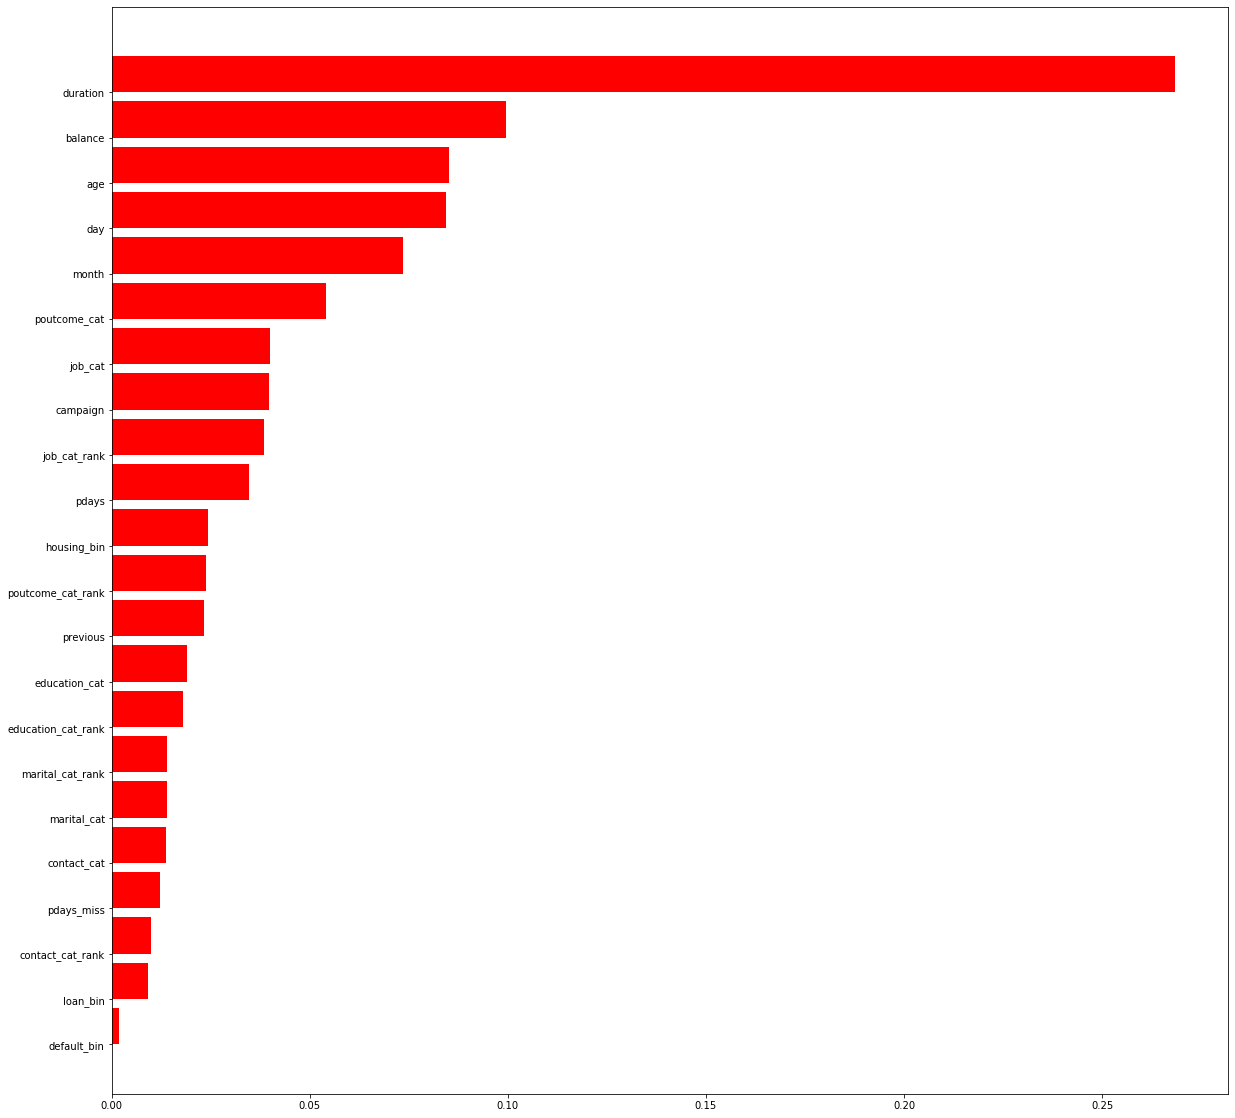

In [391]:
##尝试建模，目标是输出特征重要性
##1.RandomForest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

no_features = ["y", "ID"]
features = train[[x for x in train.columns if x not in no_features]].columns[:]

seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(train[features], train.y, test_size=test_size, random_state=seed, )


model_fe_rf = RandomForestClassifier()
model_fe_rf.fit(X_train, y_train)
###重要性排序
importance = model_fe_rf.feature_importances_
features_sort = features[np.argsort(importance)[::-1]]
importance_sort = importance[np.argsort(importance)[::-1]]
plt.figure(figsize = (20,20))
sorted_idx = np.argsort(importance)[::-1]
pos = np.arange(sorted_idx.shape[0]) + .5
plt.barh(pos, importance[sorted_idx[::-1]],color='r',align='edge')
plt.yticks(pos, features[sorted_idx[::-1]])

([<matplotlib.axis.YTick at 0x7f67b45ebb00>,
 <a list of 22 Text yticklabel objects>)

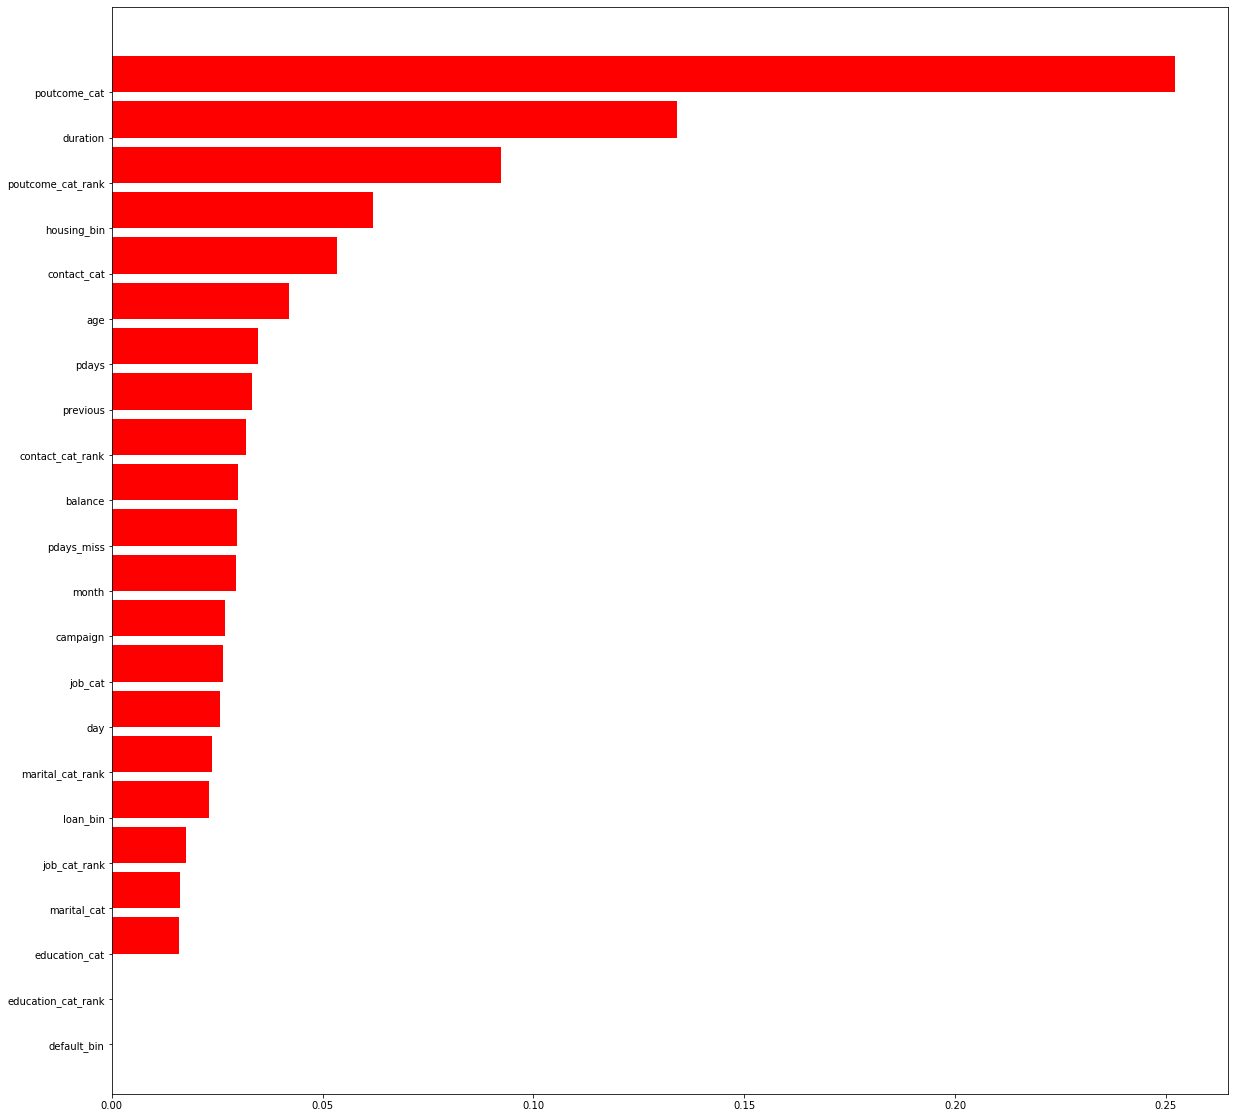

In [392]:
##2.XGBoost
import xgboost as xgb
from xgboost import XGBClassifier
model_fe_xgb = XGBClassifier(    
                        n_estimators=70,
                        max_depth=6,
                        objective="binary:logistic",
                        subsample=.8,
                        min_child_weight=6,
                        colsample_bytree=.8,
                        scale_pos_weight=1.6,
                        gamma=10,
                        reg_alpha=8,
                        reg_lambda=1.3,
                     )
model_fe_xgb.fit(X_train, y_train)
###重要性排序
importance = model_fe_xgb.feature_importances_
features_sort = features[np.argsort(importance)[::-1]]
importance_sort = importance[np.argsort(importance)[::-1]]
plt.figure(figsize = (20,20))
sorted_idx = np.argsort(importance)[::-1]
pos = np.arange(sorted_idx.shape[0]) + .5
plt.barh(pos, importance[sorted_idx[::-1]],color='r',align='edge')
plt.yticks(pos, features[sorted_idx[::-1]])

In [397]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
xgb_pred = model_fe_xgb.predict_proba(X_test)
xgb_auc1 = roc_auc_score(y_test, model_fe_xgb.predict_proba(X_test)[:,1:])
rf_auc1 = roc_auc_score(y_test, model_fe_rf.predict_proba(X_test)[:,1:])
print(xgb_auc1, rf_auc1)

0.9271849980619378 0.8832143764117779


In [433]:
predictions = model_fe_xgb.predict_proba(test[features])[:,1:]
sub=test[['ID']]
sub['pred']=predictions

In [436]:
sub.to_csv('/root/kesai/Result.csv',index=False)

In [437]:
sub.shape

(10852, 2)

In [439]:
sub.head()

,ID,pred
0,25318,0.121841
1,25319,0.048241
2,25320,0.034358
3,25321,0.667159
4,25322,0.117982


In [442]:
test.head()

,ID,age,job_cat,marital_cat,education_cat,default_bin,balance,housing_bin,loan_bin,contact_cat,...,campaign,pdays,previous,poutcome_cat,pdays_miss,marital_cat_rank,education_cat_rank,contact_cat_rank,poutcome_cat_rank,job_cat_rank
0,25318,51,0.087481,0.102657,NaN,0,174.0,0,0,0.142249,...,3,NaN,0,NaN,1.0,2,0.0,2.0,0.0,1.0
1,25319,32,0.138973,0.102657,0.150262,0,6059.0,1,0,0.148923,...,2,NaN,0,NaN,1.0,2,1.0,0.0,0.0,3.0
2,25320,60,0.234093,0.102657,0.084200,0,0.0,0,0,0.142249,...,3,NaN,0,NaN,1.0,2,2.0,2.0,0.0,11.0
3,25321,32,0.268293,0.146430,0.150262,0,64.0,0,0,0.148923,...,4,105.0,5,0.127971,0.0,0,1.0,0.0,0.0,5.0
4,25322,41,0.087481,0.102657,0.104885,0,0.0,1,1,0.148923,...,4,NaN,0,NaN,1.0,2,0.0,0.0,0.0,1.0


In [472]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV
import time
model = XGBClassifier(nthread=4, learning_rate=0.16, max_depth=6, n_estimators=100)

cv_split = ShuffleSplit(n_splits=6, train_size=0.7, test_size=0.2)
param_grid = dict(
    max_depth = [6, 7],
    learning_rate = np.linspace(0.150, 0.05, 1),
    n_estimators = [90, 100]
)
start = time.time()
grid = GridSearchCV(model, param_grid, cv=cv_split, scoring='neg_mean_squared_error')
grid.fit(X_train, y_train)
print('GridSearchCV process use %.2f seconds'%(time.time()-start))

print(grid.best_params_)

GridSearchCV process use 9.20 seconds
{'learning_rate': 0.15, 'max_depth': 6, 'n_estimators': 100}


In [490]:
model = XGBClassifier(nthread=4,learning_rate=0.16, max_depth=6, n_estimators=90)
model.fit(X_train, y_train)
auc = roc_auc_score(y_test, model.predict_proba(X_test)[:,1:])
print(auc)

0.9335890238849459


0.9334661908389805


In [488]:
import tensorflow as tf
x = tf.placeholder(tf.float32,shape=[None,X_train.shape[1]])
y = tf.placeholder(tf.float32,shape=[None])


m = 20
learning_rate = 0.3
u = tf.Variable(tf.random_normal([X_train.shape[1],m],0.0,0.5),name='u')
w = tf.Variable(tf.random_normal([X_train.shape[1],m],0.0,0.5),name='w')

U = tf.matmul(x,u)
p1 = tf.nn.softmax(U)

W = tf.matmul(x,w)
p2 = tf.nn.sigmoid(W)

pred = tf.reduce_sum(tf.multiply(p1,p2),1)

cost1=tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=pred, labels=y))
cost=tf.add_n([cost1])
train_op = tf.train.FtrlOptimizer(learning_rate).minimize(cost)


time_s=time.time()
result = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(0, 10000):
        f_dict = {x: X_train, y: y_train}
        _, cost_, predict_ = sess.run([train_op, cost, pred], feed_dict=f_dict)
        auc = roc_auc_score(y_train, predict_)
        time_t = time.time()
        if epoch % 100 == 0:
            f_dict = {x: X_test, y: y_test}
            _, cost_, predict_test = sess.run([train_op, cost, pred], feed_dict=f_dict)
            test_auc = roc_auc_score(y_test, predict_test)
            print("%d %ld cost:%f,train_auc:%f,test_auc:%f" % (epoch, (time_t - time_s), cost_, auc, test_auc))
            result.append([epoch,(time_t - time_s),auc,test_auc])

0 0 cost:0.725197,train_auc:0.557191,test_auc:0.609207
100 0 cost:0.698298,train_auc:0.475018,test_auc:0.480700
200 1 cost:0.695649,train_auc:0.476320,test_auc:0.481870
300 2 cost:0.694268,train_auc:0.477820,test_auc:0.483556
400 2 cost:0.694101,train_auc:0.479087,test_auc:0.483461
500 3 cost:0.694027,train_auc:0.479287,test_auc:0.483461
600 4 cost:0.693888,train_auc:0.479421,test_auc:0.483530
700 4 cost:0.693888,train_auc:0.479421,test_auc:0.483530
800 5 cost:0.693740,train_auc:0.479687,test_auc:0.483804
900 6 cost:0.693623,train_auc:0.479954,test_auc:0.483873
1000 7 cost:0.693443,train_auc:0.480387,test_auc:0.484079
1100 7 cost:0.693443,train_auc:0.480387,test_auc:0.484079
1200 8 cost:0.693443,train_auc:0.480421,test_auc:0.484079
1300 9 cost:0.693443,train_auc:0.480421,test_auc:0.484079
1400 9 cost:0.693443,train_auc:0.480387,test_auc:0.484079
1500 10 cost:0.693443,train_auc:0.480387,test_auc:0.484079
1600 11 cost:0.693443,train_auc:0.480421,test_auc:0.484079
1700 11 cost:0.693443,tr

KeyboardInterrupt: 

In [491]:
from sklearn.preprocessing.data import OneHotEncoder
from sklearn.linear_model import LogisticRegression

X_train_leaves = model.apply(X_train)
X_test_leaves = model.apply(X_test)

# 合并编码后的训练数据和测试数据
All_leaves = np.concatenate((X_train_leaves, X_test_leaves), axis=0)
All_leaves = All_leaves.astype(np.int32)
print("All_leaves", All_leaves, "shape", All_leaves.shape)

# 对所有特征进行ont-hot编码
xgbenc = OneHotEncoder()
X_trans = xgbenc.fit_transform(All_leaves)
(train_rows, cols) = X_train_leaves.shape
print("X_trans_shape", X_trans.shape)

# 定义LR模型
lr = LogisticRegression()
# lr对xgboost特征编码后的样本模型训练
lr.fit(X_trans[:train_rows, :], y_train)
# 预测及AUC评测
y_pred_xgblr1 = lr.predict_proba(X_trans[train_rows:, :])[:, 1]
xgb_lr_auc1 = roc_auc_score(y_test, y_pred_xgblr1)
print('基于Xgb特征编码后的LR AUC: %.5f' % xgb_lr_auc1)

All_leaves [[66 68 63 ... 56 52 31]
 [62 63 62 ... 60 52 33]
 [66 68 63 ... 81 49 33]
 ...
 [85 86 83 ... 60 52 33]
 [69 71 65 ... 51 47 33]
 [73 75 67 ... 81 47 33]] shape (25317, 90)
X_trans_shape (25317, 3455)
基于Xgb特征编码后的LR AUC: 0.91339


In [493]:
from scipy.sparse import hstack
lr = LogisticRegression(n_jobs=-1)
# 组合特征
X_train_ext = hstack([X_trans[:train_rows, :], X_train])
X_test_ext = hstack([X_trans[train_rows:, :], X_test])
print(X_test_ext.shape)

# lr对组合特征的样本模型训练
lr.fit(X_train_ext, y_train)

# 预测及AUC评测
y_pred_xgblr2 = lr.predict_proba(X_test_ext)[:, 1]
xgb_lr_auc2 = roc_auc_score(y_test, y_pred_xgblr2)
print('基于组合特征的LR AUC: %.5f' % xgb_lr_auc2)

(8355, 3477)
基于组合特征的LR AUC: 0.91609


In [495]:
import tensorflow as tf
import time
from numpy import loadtxt
from sklearn.metrics import roc_auc_score
import pandas as pd
from sklearn.model_selection import train_test_split


X_trans_1 = xgbenc.fit_transform(All_leaves).toarray()
(train_rows_1, cols_1) = X_train_leaves.shape
print("X_trans_shape", X_trans_1.shape)

x = tf.placeholder(tf.float32,shape=[None,X_trans_1.shape[1]])
y = tf.placeholder(tf.float32,shape=[None])


m = 2
learning_rate = 0.3
u = tf.Variable(tf.random_normal([X_trans_1.shape[1],m],0.0,0.5),name='u')
w = tf.Variable(tf.random_normal([X_trans_1.shape[1],m],0.0,0.5),name='w')

U = tf.matmul(x,u)
p1 = tf.nn.softmax(U)

W = tf.matmul(x,w)
p2 = tf.nn.sigmoid(W)

pred = tf.reduce_sum(tf.multiply(p1,p2),1)
print('x, y, p1, p2, pred', x.shape, y.shape, p1.shape, p2.shape, pred.shape)

cost1=tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=pred, labels=y))
cost=tf.add_n([cost1])
train_op = tf.train.FtrlOptimizer(learning_rate).minimize(cost)


time_s=time.time()
result = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(0, 10000):
        f_dict = {x: X_trans_1[:train_rows, :], y: y_train}
        _, cost_, predict_ = sess.run([train_op, cost, pred], feed_dict=f_dict)
        auc = roc_auc_score(y_train, predict_)
        time_t = time.time()
        if epoch % 100 == 0:
            f_dict = {x: X_trans_1[train_rows:], y: y_test}
            _, cost_, predict_test = sess.run([train_op, cost, pred], feed_dict=f_dict)
            test_auc = roc_auc_score(y_test, predict_test)
            print("%d %ld cost:%f,train_auc:%f,test_auc:%f" % (epoch, (time_t - time_s), cost_, auc, test_auc))
            result.append([epoch,(time_t - time_s),auc,test_auc])

X_trans_shape (25317, 3455)
x, y, p1, p2, pred (?, 3455) (?,) (?, 2) (?, 2) (?,)
0 0 cost:0.868976,train_auc:0.334527,test_auc:0.770635
100 18 cost:0.693746,train_auc:0.834137,test_auc:0.826123
200 36 cost:0.693432,train_auc:0.838731,test_auc:0.830477
300 56 cost:0.693327,train_auc:0.842081,test_auc:0.833651
400 74 cost:0.693273,train_auc:0.844934,test_auc:0.836385
500 92 cost:0.693240,train_auc:0.847510,test_auc:0.838850
600 115 cost:0.693217,train_auc:0.849953,test_auc:0.841170
700 133 cost:0.693200,train_auc:0.852325,test_auc:0.843384
800 152 cost:0.693185,train_auc:0.854682,test_auc:0.845628
900 170 cost:0.693173,train_auc:0.857040,test_auc:0.847923
1000 188 cost:0.693161,train_auc:0.859484,test_auc:0.850275
1100 211 cost:0.693148,train_auc:0.862078,test_auc:0.852786
1200 229 cost:0.693134,train_auc:0.864939,test_auc:0.855602
1300 247 cost:0.693114,train_auc:0.868215,test_auc:0.858854
1400 266 cost:0.693082,train_auc:0.872478,test_auc:0.863051
1500 284 cost:0.692995,train_auc:0.879

KeyboardInterrupt: 

In [511]:
from sklearn.model_selection import KFold
param = {'max_depth': 6,
         'learning_rate ': 0.16,
         'silent': 1,
         'objective': 'binary:logistic',
         "eval_metric":"auc",
         "scale_pos_weight":10,
         "subsample":0.8,
         "min_child_weight":1,
          }
dtrain = xgb.DMatrix(X_train,label=y_train)
dtest  = xgb.DMatrix(X_test)

cv_res = xgb.cv(param,dtrain,num_boost_round=2000,early_stopping_rounds=10,nfold=10, metrics='auc',show_stdv=True)
bst = xgb.train(param,dtrain,num_boost_round=cv_res.shape[0])

y_pre = bst.predict(dtest)
print(roc_auc_score(y_test, bst.predict(dtest)))
res = pd.concat([test[["ID"]],pd.DataFrame(y_pre,columns=["pred"])],axis=1)
res.to_csv("/root/kesai/cv_res.csv",index=False)

0.9261987248887285


In [512]:
model = XGBClassifier(nthread=4,learning_rate=0.16, max_depth=6, n_estimators=90)
model.fit(train[features], train.y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.16, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=90, n_jobs=1,
              nthread=4, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [513]:
y_pre = model.predict_proba(test["features"])
res = pd.concat([test[["ID"]],pd.DataFrame(y_pre,columns=["pred"])],axis=1)
res.to_csv("/root/kesai/Result2.csv",index=False)

KeyError: 'features'